INITIAL SETUP

In [0]:
# creating a year variable and setting  a basefile
year = "2021"

basefile = "clinicaltrial_" + year

dbutils.fs.cp("/FileStore/tables/" + basefile + ".zip", "file:/tmp/")

dbutils.fs.cp("/FileStore/tables/pharma.zip", "file:/tmp/")

Out[1]: True

In [0]:
#assigning basefile as the environment variable
import os

os.environ['basefile'] = basefile

In [0]:
%sh
# unzipping the basefile into a temporary folder
unzip -d /tmp /tmp/$basefile.zip  

# unzipping the pharma.zip
unzip -d /tmp /tmp/pharma.zip


Archive:  /tmp/clinicaltrial_2021.zip
  inflating: /tmp/clinicaltrial_2021.csv  
Archive:  /tmp/pharma.zip
  inflating: /tmp/pharma.csv         


In [0]:
#creating directory for the basefile in the Filestore/tables
dbutils.fs.mkdirs("/FileStore/tables/" + basefile)
#moving the file from the temporary folder to DBFS
dbutils.fs.mv("file:/tmp/" +basefile + ".csv" , "/FileStore/tables/" +basefile + ".csv" , True)

#creating the directory for the pharma unzipped file
dbutils.fs.mkdirs('FileStore/tables/pharma')
#moving the pharma.csv from the temporary folder to DBFS
dbutils.fs.mv('File:/tmp/pharma.csv', '/FileStore/tables/pharma', True)


Out[4]: True

In [0]:
#reading the file into RDD
clinicaltrial_RDD=sc.textFile('/FileStore/tables/' +basefile + '.csv')
#reading the pharma file into RDD
pharma_RDD = sc.textFile('/FileStore/tables/pharma')

DATA EXPLORATION AND PREPROCESSING

In [0]:
#viewing the clinicaltrial_RDD
clinicaltrial_RDD.collect()

Out[6]: ['Id|Sponsor|Status|Start|Completion|Type|Submission|Conditions|Interventions',
 'NCT02758028|The University of Hong Kong|Recruiting|Aug 2005|Nov 2021|Interventional|Apr 2016||',
 'NCT02751957|Duke University|Completed|Jul 2016|Jul 2020|Interventional|Apr 2016|Autistic Disorder,Autism Spectrum Disorder|',
 'NCT02758483|Universidade Federal do Rio de Janeiro|Completed|Mar 2017|Jan 2018|Interventional|Apr 2016|Diabetes Mellitus|',
 'NCT02759848|Istanbul Medeniyet University|Completed|Jan 2012|Dec 2014|Observational|May 2016|Tuberculosis,Lung Diseases,Pulmonary Disease|',
 'NCT02758860|University of Roma La Sapienza|Active, not recruiting|Jun 2016|Sep 2020|Observational [Patient Registry]|Apr 2016|Diverticular Diseases,Diverticulum,Diverticulosis|',
 'NCT02757209|Consorzio Futuro in Ricerca|Completed|Apr 2016|Jan 2018|Interventional|Apr 2016|Asthma|Fluticasone,Xhance,Budesonide,Formoterol Fumarate,Salmeterol Xinafoate',
 'NCT02752438|Ankara University|Unknown status|May 2016|Jul 2

In [0]:
#count of number of columns in the dataset
first_row1 = clinicaltrial_RDD.first()

print('number of columns in clinicaltrial data:',len(first_row1.split("|")))
#count of number of rows (minus 1 is used to exclude the header column)
num_of_rows = clinicaltrial_RDD.count()-1
print('number of rows: ',num_of_rows)


number of columns in clinicaltrial data: 9
number of rows:  387261


In [0]:
#removing the header row for clinicaltrial data.
header = clinicaltrial_RDD.first()
clinicaltrial_RDD_NH =clinicaltrial_RDD.filter(lambda row: row !=header)

#removing the first row for pharma data
header2 = pharma_RDD.first()
pharma_RDD_NH = pharma_RDD.filter(lambda row: row != header2)

In [0]:
#Check that the header row has been removed
clinicaltrial_RDD_NH.take(1)

Out[9]: ['NCT02758028|The University of Hong Kong|Recruiting|Aug 2005|Nov 2021|Interventional|Apr 2016||']

In [0]:
#checking for missing values in the row
rows_with_missing_values = clinicaltrial_RDD_NH.filter(lambda row: "null" in row or "NaN" in row)
#show the row with missing value
rows_with_missing_values.collect()

Out[10]: ['NCT04381455|Studio Odontoiatrico Associato Dr. P. Cicchese e L. Canullo|Active, not recruiting|May 2020|Jun 2022|Observational|May 2020||']

In [0]:
clinicaltrial_RDD_NH.collect()

Out[11]: ['NCT02758028|The University of Hong Kong|Recruiting|Aug 2005|Nov 2021|Interventional|Apr 2016||',
 'NCT02751957|Duke University|Completed|Jul 2016|Jul 2020|Interventional|Apr 2016|Autistic Disorder,Autism Spectrum Disorder|',
 'NCT02758483|Universidade Federal do Rio de Janeiro|Completed|Mar 2017|Jan 2018|Interventional|Apr 2016|Diabetes Mellitus|',
 'NCT02759848|Istanbul Medeniyet University|Completed|Jan 2012|Dec 2014|Observational|May 2016|Tuberculosis,Lung Diseases,Pulmonary Disease|',
 'NCT02758860|University of Roma La Sapienza|Active, not recruiting|Jun 2016|Sep 2020|Observational [Patient Registry]|Apr 2016|Diverticular Diseases,Diverticulum,Diverticulosis|',
 'NCT02757209|Consorzio Futuro in Ricerca|Completed|Apr 2016|Jan 2018|Interventional|Apr 2016|Asthma|Fluticasone,Xhance,Budesonide,Formoterol Fumarate,Salmeterol Xinafoate',
 'NCT02752438|Ankara University|Unknown status|May 2016|Jul 2017|Observational [Patient Registry]|Apr 2016|Hypoventilation|',
 'NCT02753543|

In [0]:
pharma_RDD.collect()

Out[12]: ['"Company","Parent_Company","Penalty_Amount","Subtraction_From_Penalty","Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting","Penalty_Year","Penalty_Date","Offense_Group","Primary_Offense","Secondary_Offense","Description","Level_of_Government","Action_Type","Agency","Civil/Criminal","Prosecution_Agreement","Court","Case_ID","Private_Litigation_Case_Title","Lawsuit_Resolution","Facility_State","City","Address","Zip","NAICS_Code","NAICS_Translation","HQ_Country_of_Parent","HQ_State_of_Parent","Ownership_Structure","Parent_Company_Stock_Ticker","Major_Industry_of_Parent","Specific_Industry_of_Parent","Info_Source","Notes"',
 '"Abbott Laboratories","Abbott Laboratories","$5,475,000","$0","$5,475,000","2013","20131227","government-contracting-related offenses","False Claims Act and related","kickbacks and bribery","Abbott Laboratories agreed to $5.475 million to resolve allegations that it violated the False Claims Act by paying kickbacks to induce doctors to implant the c

In [0]:
#count of number of columns in the dataset
first_row = pharma_RDD.first()

print('number of columns in pharma data:',len(first_row.split(",")))
#count of number of rows (minus 1 is used to exclude the header column)
num_of_rows = pharma_RDD.count()-1
print('number of rows: ',num_of_rows)

number of columns in pharma data: 34
number of rows:  968


Question 1
Number of distinct studies

In [0]:
#split the RDD at delimiter
split_rdd = clinicaltrial_RDD_NH.map(lambda line: line.split("|"))
#select the first column which is the ID column
ID_column_rdd = split_rdd.map(lambda x: x[0])
#count the distinct values
column_count = ID_column_rdd.distinct().count()
#print out the column count
print('number of distinct studies:', column_count)

number of distinct studies: 387261


Question2: Type of Studies and frequency ordered by most to least

In [0]:
# first, we count the number of studies by type
counts_by_type  = clinicaltrial_RDD_NH.map(lambda s:(s.split("|")[5], 1)).reduceByKey(lambda a,b: a + b).sortBy(lambda x: x[1], ascending=False)

#print the type counts and the corresponding numbers
for type_count in counts_by_type.collect():
    print(type_count[0],'=', type_count[1])

Interventional = 301472
Observational = 77540
Observational [Patient Registry] = 8180
Expanded Access = 69


Question3: Top 5 conditions with their frequencies

In [0]:
# Split on '|', select the Conditions column and explode using flatmap
condition_rdd = clinicaltrial_RDD_NH.map(lambda x: x.split('|')[7]) \
                        .flatMap(lambda x: x.split(','))

# Count the frequency of each condition
conditions_count = condition_rdd.map(lambda x: (x.strip(), 1)) \
                               .reduceByKey(lambda x, y: x + y) \
                               .sortBy(lambda x: x[1], ascending=False) \
                               .filter(lambda x: x[0].strip())
#get the top 5 conditions
top5_condition = conditions_count.take(5)                  
#display the result

for condition_count  in top5_condition:
  

   # print(condition_count[0][0], '=', condition_count[1])

     print("{:<25}{}".format(condition_count[0], condition_count[1]))

Carcinoma                13389
Diabetes Mellitus        11080
Neoplasms                9371
Breast Neoplasms         8640
Syndrome                 8032


Question4 : Top 10 common sponsors that are pharmaceutical companies

In [0]:
#removing the double quotation in pharmaRDD, splitting at comma delimiter and selecting the distinct values in the parent company column
pharma_RDD_NH2 =pharma_RDD_NH.map(lambda x: x.replace('"', '')).map(lambda s:(s.split(",")[1])).distinct()

#selecting only the sponsor column of clinicaltrial_RDD_NH
clinicaltrial_RDD_NH2 = clinicaltrial_RDD_NH.map(lambda x: x.split('|')[1])

#filtering out of non_pharma data by selecting only sponsors that dont appear in pharma dataset
non_pharma_RDD = clinicaltrial_RDD_NH2.subtract(pharma_RDD_NH2)

#counting, grouping and sorting the distinct non_pharma sponsors in descending order according to count
counts_of_non_pharma  = non_pharma_RDD.map(lambda x: (x, 1)).reduceByKey(lambda a, b: a + b).sortBy(lambda x: x[1], ascending=False)

#displaying the top 10
counts_of_non_pharma.take(10)


Out[17]: [('National Cancer Institute (NCI)', 3218),
 ('M.D. Anderson Cancer Center', 2414),
 ('Assistance Publique - Hôpitaux de Paris', 2369),
 ('Mayo Clinic', 2300),
 ('Merck Sharp & Dohme Corp.', 2243),
 ('Assiut University', 2154),
 ('Novartis Pharmaceuticals', 2088),
 ('Massachusetts General Hospital', 1971),
 ('Cairo University', 1928),
 ('Hoffmann-La Roche', 1828)]

no5: no of completed studies each each month in a given year

In [0]:
#import the datetime function for converting to date and calender for sorting the months
from datetime import datetime
import calendar

#extract the studies with status 'completed' and in which completion has year = '2021'
Completed_Studies_in_year = clinicaltrial_RDD_NH.filter(lambda x: x.split("|")[2] == "Completed" and x.split("|")[4].endswith(year))

#extracting the month and year from the completion date and mapping them to (month, 1)
Completed_Studies_in_year = Completed_Studies_in_year.map(lambda x: (datetime.strptime(x.split("|")[4], '%b %Y').month,1))

#sort the result by month key
Completed_Studies_in_year = Completed_Studies_in_year.reduceByKey(lambda x,y: x + y).sortByKey()

#map the month number to its name
Completed_Studies_in_year = Completed_Studies_in_year.map(lambda x: (calendar.month_name[x[0]],x[1]))

In [0]:
Completed_Studies_in_year.take(12)

Out[19]: [('January', 1131),
 ('February', 934),
 ('March', 1227),
 ('April', 967),
 ('May', 984),
 ('June', 1094),
 ('July', 819),
 ('August', 700),
 ('September', 528),
 ('October', 187)]

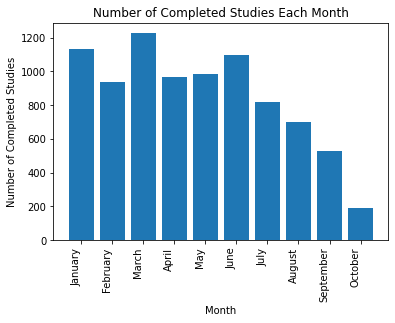

In [0]:
#creating a barchart visualisation with completed_studies
import matplotlib.pyplot as plt

# The data
dataset = Completed_Studies_in_year.take(12)

# Extract the month names and counts into separate lists
months = [item[0] for item in dataset]
counts = [item[1] for item in dataset]

# Create a bar chart
fig, ax = plt.subplots()
ax.bar(months, counts)

# Set the chart title and axis labels
ax.set_title('Number of Completed Studies Each Month')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Completed Studies')

# Rotate the x-axis labels to make them easier to read
plt.xticks(rotation=90, ha='right')

# Display the chart
plt.show()


FURTHER ANALYSIS

In [0]:
# To find the sponsors with the highest completed studies
# we first filter out all the completed studies

Completed_Studies = clinicaltrial_RDD_NH.filter(lambda x: x.split("|")[2] == "Completed")

#selecting only the sponsor 
Sponsors_with_completed_studies = Completed_Studies.map(lambda x: x.split('|')[1])

#counting, grouping and sorting sponspors with completed studies in descending order according to count
count_of_sponsors_with_completed_studies  = Sponsors_with_completed_studies.map(lambda x: (x, 1)).reduceByKey(lambda a, b: a + b).sortBy(lambda x: x[1], ascending=False)
#selecting the top 10 and displaying them
count_of_sponsors_with_completed_studies.take(10)
for sponsor, count in count_of_sponsors_with_completed_studies.take(10):
    print("{:<40}{}".format(sponsor, count))

GlaxoSmithKline                         2929
AstraZeneca                             2125
Pfizer                                  1949
National Cancer Institute (NCI)         1897
Boehringer Ingelheim                    1712
Merck Sharp & Dohme Corp.               1693
Novartis Pharmaceuticals                1411
Hoffmann-La Roche                       1379
Eli Lilly and Company                   1355
Bayer                                   1214
